# **Data Analysis on Ischaemic Heart Disease**

In 2019, the World Health Organization (WHO) declared that Ischaemic Heart Disease is the leading cause of death worldwide, accounting for 16% of all deaths <a href="#ref-01">[1]</a>. They also mentioned that annual deaths among men were around 15% more than women <a href="#ref-02">[2]</a>.

## Table of Contents

1. <a href="#toc-01">Import Dataset and Data Transformation</a>
2. <a href="#toc-02">Exploratory Data Analysis</a>
3. <a href="#toc-03">Model Creation and Evaluation</a>
5. <a href="#toc-04">Make Test Predications</a>
6. <a href="#toc-05">References</a>

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

import warnings
warnings.filterwarnings("ignore")

## Import Dataset and Data Transformation<a id="toc-01"></a>

Dataset for income grouping was taken from <a href="https://www.who.int/docs/default-source/gho-documents/global-health-estimates/ghe2019_cod_methods.pdf">WHO methods and data sources of country-level causes of death (p. 49)</a>.

After reading data from the source, all records with missing data under income_grouping will be dropped as this category is necessary for data analysis.

In [183]:
income_grouping_2019 = pd.read_csv('./datasets/World Bank Income Grouping 2019.csv')

income_grouping_2019.dropna(inplace=True)   # Drop all rows with NaN values
income_grouping_2019.reset_index(inplace=True, drop=True)

income_grouping_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   region_code      109 non-null    object
 1   region_name      109 non-null    object
 2   country_code     109 non-null    object
 3   country_name     109 non-null    object
 4   income_grouping  109 non-null    object
dtypes: object(5)
memory usage: 4.4+ KB


Dataset for Ischaemic Heart Disease was taken from <a href="https://platform.who.int/mortality/themes/theme-details/topics/indicator-groups/indicator-group-details/MDB/ischaemic-heart-disease">WHO's interactive platform for mortality data</a>.

After reading data from the source, the records are filtered by
- <b>Sex</b>: Male and Female only (removing 'Unknown' and 'All' from the list)
- <b>Age Group</b>: Remove 'All' and 'Unknown'
- <b>Year</b>: Take only data from 1963 to 2019
    - Records before 1963 do not have data for Low Middle Income
    - Records for 2020 is incomplete
- <b>Date Rate per 100,000</b>: Remove records with zero values

In [184]:
ihd_df = pd.read_csv('./datasets/Ischaemic Heart Disease.csv')

ihd_df_filtered = ihd_df.fillna(0)  # Fill all NaN cells with 0
# ihd_df_filtered = ihd_df_filtered.query("sex == ['Male', 'Female'] and age_group != ['[All]', '[Unknown]'] and (year >= 1963 and year < 2020) ")
ihd_df_filtered = ihd_df_filtered.query("sex == ['Male', 'Female'] and age_group != ['[All]', '[Unknown]'] and (year >= 1963 and year < 2020) and death_rate_per_100000 != 0")

ihd_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163210 entries, 22 to 296540
Data columns (total 12 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   region_code                                           163210 non-null  object 
 1   region_name                                           163210 non-null  object 
 2   country_code                                          163210 non-null  object 
 3   country_name                                          163210 non-null  object 
 4   year                                                  163210 non-null  int64  
 5   sex                                                   163210 non-null  object 
 6   age_group_code                                        163210 non-null  object 
 7   age_group                                             163210 non-null  object 
 8   num_of_death                               

Merge the necessary fields from Ischeamic Heart Disease and Income Grouping tables

In [185]:
ihd_with_ig_df = ihd_df_filtered[['country_code', 'year', 'sex', 'age_group', 'death_rate_per_100000']].merge(income_grouping_2019[['country_code', 'income_grouping']], on='country_code')

ihd_with_ig_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159752 entries, 0 to 159751
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country_code           159752 non-null  object 
 1   year                   159752 non-null  int64  
 2   sex                    159752 non-null  object 
 3   age_group              159752 non-null  object 
 4   death_rate_per_100000  159752 non-null  float64
 5   income_grouping        159752 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 8.5+ MB


Rename the age group category based from Statistics Canada's <a href="https://www.statcan.gc.ca/en/concepts/definitions/age2">Age Categories, Life Cycle Groupings</a>
- <b>Children</b>: 00-14 years
- <b>Youth</b>: 15-24 years
- <b>Adults</b>: 25-64 years
- <b>Seniors</b>: 65 years and over

In [186]:
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[0]', 'Children', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[1-4]', 'Children', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[5-9]', 'Children', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[10-14]', 'Children', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[15-19]', 'Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[20-24]', 'Youth', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[25-29]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[30-34]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[35-39]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[40-44]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[45-49]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[50-54]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[55-59]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[60-64]', 'Adults', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[65-69]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[70-74]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[75-79]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[80-84]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[85+]', 'Seniors', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'].value_counts()

# ihd_with_ig_df.groupby(['age_group', 'sex'])['death_rate_per_100000'].describe()

Adults      67264
Seniors     42040
Children    33632
Youth       16816
Name: age_group, dtype: int64

## Exploratory Data Analysis<a id="toc-02"></a>

### Data Analysis on Income Grouping per Year

Group the records by `income_grouping` then display the summary statistics of `death_rate_per_100000` for each `income_grouping`. 

**NOTE**: WHO didn't provide records for Low Income grouping. Hence, it is excluded from the study.

In [187]:
ihd_with_ig_grp_income = ihd_with_ig_df.groupby(['income_grouping']) 

ihd_with_ig_grp_income['death_rate_per_100000'].describe()

,count,mean,std,min,25%,50%,75%,max
income_grouping,,,,,,,,
High Income,87552.0,436.019857,1138.862327,0.0,0.000000,9.736116,269.784231,26000.00000
Low Middle Income,14934.0,709.890154,1936.308677,0.0,1.043743,20.255848,307.993994,20608.95823
Upper Middle Income,57266.0,367.902621,1051.257164,0.0,0.000000,10.339872,223.535812,19016.29073


Extract the records for `High Income` category. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [188]:
ihd_with_ig_grpby_high_income = ihd_with_ig_grp_income.get_group('High Income')
ihd_with_ig_grpby_high_income_and_year = ihd_with_ig_grpby_high_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_high_income = ihd_with_ig_grpby_high_income_and_year['year']
death_rate_per_100000_by_high_income = ihd_with_ig_grpby_high_income_and_year['death_rate_per_100000']

ihd_with_ig_grpby_high_income_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   57 non-null     int64  
 1   death_rate_per_100000  57 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


Extract the records for `Upper Middle Income` category. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [189]:
ihd_with_ig_grpby_upper_middle_income = ihd_with_ig_grp_income.get_group('Upper Middle Income')
ihd_with_ig_grpby_upper_middle_income_and_year = ihd_with_ig_grpby_upper_middle_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_upper_mid_income = ihd_with_ig_grpby_upper_middle_income_and_year['year']
death_rate_per_100000_by_upper_mid_income = ihd_with_ig_grpby_upper_middle_income_and_year['death_rate_per_100000']

ihd_with_ig_grpby_upper_middle_income_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   57 non-null     int64  
 1   death_rate_per_100000  57 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


Extract the records for `Low Middle Income` category. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [190]:
ihd_with_ig_grpby_low_middle_income = ihd_with_ig_grp_income.get_group('Low Middle Income')
ihd_with_ig_grpby_low_middle_income_and_year = ihd_with_ig_grpby_low_middle_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_low_mid_income = ihd_with_ig_grpby_low_middle_income_and_year['year']
death_rate_per_100000_by_low_mid_income = ihd_with_ig_grpby_low_middle_income_and_year['death_rate_per_100000']

ihd_with_ig_grpby_low_middle_income_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   56 non-null     int64  
 1   death_rate_per_100000  56 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


Plot on the scatterplot the `year` and `death_rate_per_100000` for each incoming grouping.

Text(1987, 1213, '1223.28')

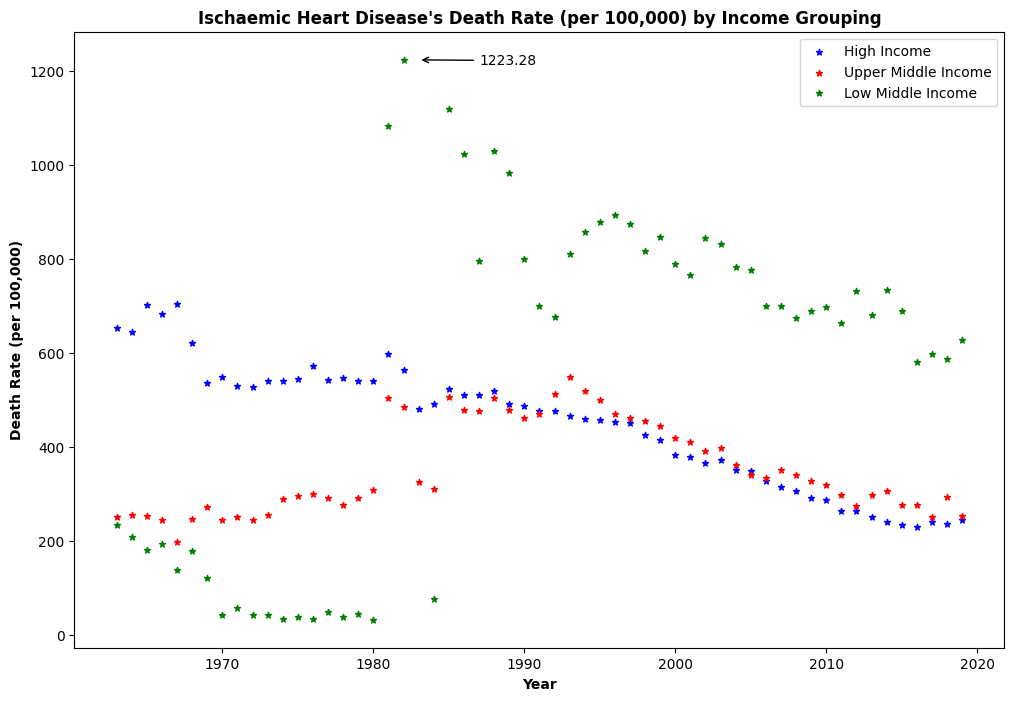

In [191]:
# Plot the graph of Death Rate per 100000 for each Year based on Income Grouping
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Year", fontdict={'weight':'bold'})
ax.set_ylabel("Death Rate (per 100,000)", fontdict={'weight':'bold'})
ax.set_title("Ischaemic Heart Disease's Death Rate (per 100,000) by Income Grouping", fontdict={'size':'large', 'weight':'bold'})

ax.scatter(year_by_high_income, death_rate_per_100000_by_high_income, s=20, c='b', label='High Income', marker='*')
ax.scatter(year_by_upper_mid_income, death_rate_per_100000_by_upper_mid_income, s=20, c='r', label='Upper Middle Income', marker='*')
ax.scatter(year_by_low_mid_income, death_rate_per_100000_by_low_mid_income, s=20, c='g', label='Low Middle Income', marker='*')
ax.legend(loc='upper right')

ax.annotate('1223.28', xy=(1983, 1223), xytext=(1987, 1213), arrowprops=dict(arrowstyle='->')) 

Based from the results, death rate of Ischaemic Heart Disease under `High Income` is slowly decreasing over the past years. However, the death rate for `Low Middle Income` has surged in the mid 80's, doubling the value of `High Income`.


### Data Analysis on Sex per Year

Group the records by `sex` then display the summary statistics of `death_rate_per_100000` for each `sex`.

In [192]:
ihd_with_ig_grp_sex = ihd_with_ig_df.groupby(['sex']) 

ihd_with_ig_grp_sex['death_rate_per_100000'].describe()  

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
Female,79876.0,359.608836,1100.102565,0.0,0.000000,5.689795,151.922425,22333.33333
Male,79876.0,514.799267,1307.665446,0.0,0.045914,22.767183,374.256023,26000.00000


Extract the records for `Male`. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [193]:
df_grpby_male = ihd_with_ig_grp_sex.get_group('Male')
df_grpby_male_and_year = df_grpby_male[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_male = df_grpby_male_and_year['year']
death_rate_per_100000_by_male = df_grpby_male_and_year['death_rate_per_100000']

df_grpby_male_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   57 non-null     int64  
 1   death_rate_per_100000  57 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


Extract the records for `Female`. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [194]:
df_grpby_female = ihd_with_ig_grp_sex.get_group('Female')
df_grpby_female_and_year = df_grpby_female[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_female = df_grpby_female_and_year['year']
death_rate_per_100000_by_female = df_grpby_female_and_year['death_rate_per_100000']

df_grpby_female_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   57 non-null     int64  
 1   death_rate_per_100000  57 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


Plot on the scatterplot the `year` and `death_rate_per_100000` for each gender.

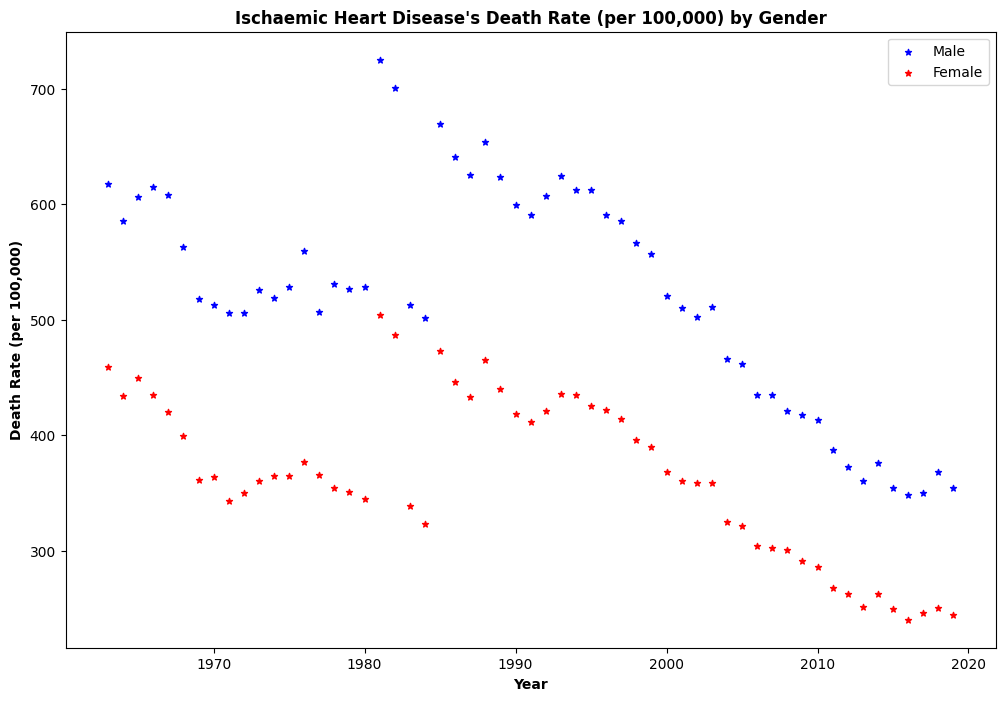

In [195]:
# Plot the graph of Death Rate per 100000 for each Year based on Sex
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Year", fontdict={'weight':'bold'})
ax.set_ylabel("Death Rate (per 100,000)", fontdict={'weight':'bold'})
ax.set_title("Ischaemic Heart Disease's Death Rate (per 100,000) by Gender", fontdict={'size':'large', 'weight':'bold'})

ax.scatter(year_by_male, death_rate_per_100000_by_male, s=20, c='b', label='Male', marker='*')
ax.scatter(year_by_female, death_rate_per_100000_by_female, s=20, c='r', label='Female', marker='*')
ax.legend(loc='upper right')

Based from the results, `Male` has a higher death rate on Ischaemic Heart Disease as compared to `Female` though the mortality rate has decreased for both gender over the years.

## Model Creation and Evaluation<a id="toc-03"></a>

### Data Preparation: Converting Categorical Features

Check the frequency counts of `income_grouping`, `sex` and `age_group`.

In [196]:
ihd_with_ig_df['income_grouping'].value_counts()

High Income            87552
Upper Middle Income    57266
Low Middle Income      14934
Name: income_grouping, dtype: int64

In [197]:
ihd_with_ig_df['sex'].value_counts()

Male      79876
Female    79876
Name: sex, dtype: int64

In [198]:
ihd_with_ig_df['age_group'].value_counts()

Adults      67264
Seniors     42040
Children    33632
Youth       16816
Name: age_group, dtype: int64

Convert `income_grouping`, `sex` and `age_group` to dummy variables with 0 or 1 as the value.

In [199]:
income_grouping_df = pd.get_dummies(ihd_with_ig_df['income_grouping'])
income_grouping_df.columns = ['high_income', 'low_middle_income', 'upper_middle_income']
income_grouping_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159752 entries, 0 to 159751
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   high_income          159752 non-null  uint8
 1   low_middle_income    159752 non-null  uint8
 2   upper_middle_income  159752 non-null  uint8
dtypes: uint8(3)
memory usage: 1.7 MB


In [200]:
male_gender_df = pd.get_dummies(ihd_with_ig_df['sex'], drop_first=True)
male_gender_df.columns = ['male_gender']
male_gender_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159752 entries, 0 to 159751
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   male_gender  159752 non-null  uint8
dtypes: uint8(1)
memory usage: 1.4 MB


In [201]:
age_grouping_df = pd.get_dummies(ihd_with_ig_df['age_group'])
age_grouping_df.columns = ['adults', 'children', 'seniors', 'youth']
age_grouping_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159752 entries, 0 to 159751
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   adults    159752 non-null  uint8
 1   children  159752 non-null  uint8
 2   seniors   159752 non-null  uint8
 3   youth     159752 non-null  uint8
dtypes: uint8(4)
memory usage: 1.8 MB


Create a dummy dataframe. Drop `income_grouping`, `sex` and `age_group` and all unnecessary column(s) from the dummy dataframe.

In [202]:
ihd_with_ig_df_dummy = ihd_with_ig_df.copy()
ihd_with_ig_df_dummy.drop(['country_code', 'sex', 'income_grouping', 'year', 'age_group'], axis=1, inplace=True)

ihd_with_ig_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159752 entries, 0 to 159751
Data columns (total 1 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   death_rate_per_100000  159752 non-null  float64
dtypes: float64(1)
memory usage: 2.4 MB


Concatenate in the dummy dataframe the dataframe (with dummy variables) created for `income_grouping`, `sex` and `age_group`.

In [203]:
ihd_with_ig_df_dummy = pd.concat([ihd_with_ig_df_dummy, male_gender_df, age_grouping_df, income_grouping_df], axis=1, verify_integrity=True)
ihd_with_ig_df_dummy.head(5)

,death_rate_per_100000,male_gender,adults,children,seniors,youth,high_income,low_middle_income,upper_middle_income
0,0.000000,1,0,1,0,0,0,0,1
1,0.000000,1,0,1,0,0,0,0,1
2,0.000000,1,0,1,0,0,0,0,1
3,0.000000,1,0,1,0,0,0,0,1
4,0.617665,1,0,0,0,1,0,0,1


Check for independence between columns. The intensity of the feature's dependency is measured by the cell's color (more dependency -> darker color)

<AxesSubplot: >

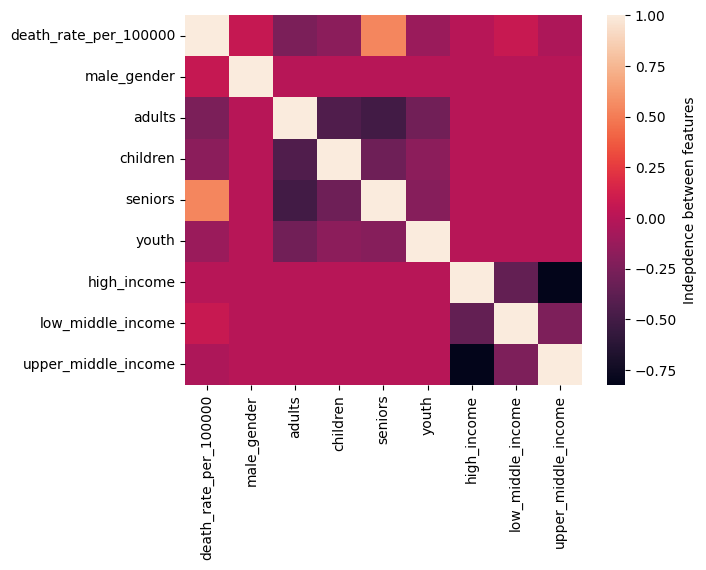

In [204]:
# Check for independence between features
sb.heatmap(ihd_with_ig_df_dummy.corr(), cbar_kws={'label': 'Indepdence between features'})

### Function Declaration

In [218]:
def evaluateModel(model, x_train, x_test, y_train, y_test, y_pred):
    '''
    This method evaluate the Logistic Regression model and provide clasification report,
    confusion matrix and precision score
    '''
    print(f"Model Score: {model.score(x_test, y_test)}\n")

    # Classification report without cross-validation
    print("Classification Report")
    print(classification_report(y_test, y_pred))

    # k-fold cross-validation and confusion matrices
    y_train_pred = cross_val_predict(model, x_train, y_train, cv=5)
    print("Confusion Matrix")

    cm = confusion_matrix(y_train, y_train_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))

    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
            
    plt.show()

    print(f"Precision Score: {precision_score(y_train, y_train_pred)}")
    
    
def modelCreation(x, y):
    '''
    This method generate training and test datasets, create Logistic Regression model.
    Then evaluate the model.
    '''
    x_train, x_test, y_train, y_test = train_test_split(x.drop(['adults', 'children', 'seniors', 'youth'], axis=1), y, test_size=0.3, random_state=0)

    print(f"No. of Train Datasets: x={x_train.shape} y={y_train.shape}")
    print(f"No. of Test Datasets: x={x_test.shape} y={y_test.shape}\n")
    
    model = LogisticRegression(solver='lbfgs')
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    evaluateModel(model, x_train, x_test, y_train, y_test, y_pred)

    return model

### Model Creation and Evaluation for each Age Group

No. of Train Datasets: x = (111826, 5) y = (111826,)
No. of Test Datasets: x = (47926, 5) y = (47926,)

Model Score: 0.9164545340733631

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     35284
           1       0.91      0.76      0.83     12642

    accuracy                           0.92     47926
   macro avg       0.92      0.86      0.89     47926
weighted avg       0.92      0.92      0.91     47926

Confusion Matrix


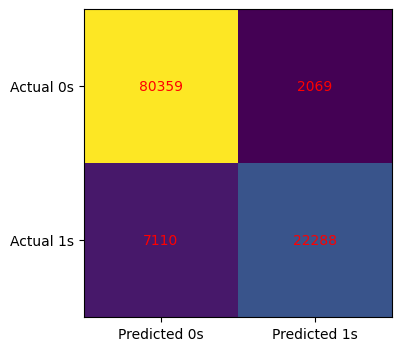

Precision Score: 0.9150552202652215


In [217]:
model_seniors = modelCreation(ihd_with_ig_df_dummy, age_grouping_df['seniors'])

No. of Train Datasets: (111826, 5) (111826,)
No. of Test Datasets: (47926, 5) (47926,)

Model Score: 0.5301297834160998

Classification Report
              precision    recall  f1-score   support

           0       0.61      0.54      0.57     27797
           1       0.45      0.52      0.48     20129

    accuracy                           0.53     47926
   macro avg       0.53      0.53      0.53     47926
weighted avg       0.54      0.53      0.53     47926

Confusion Matrix


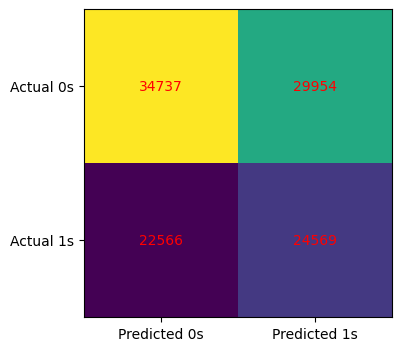

Precision Score: 0.450617170735286


In [207]:
model_adults = modelCreation(ihd_with_ig_df_dummy, age_grouping_df['adults'])

No. of Train Datasets: (111826, 5) (111826,)
No. of Test Datasets: (47926, 5) (47926,)

Model Score: 0.8939197930142303

Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     42842
           1       0.00      0.00      0.00      5084

    accuracy                           0.89     47926
   macro avg       0.45      0.50      0.47     47926
weighted avg       0.80      0.89      0.84     47926

Confusion Matrix


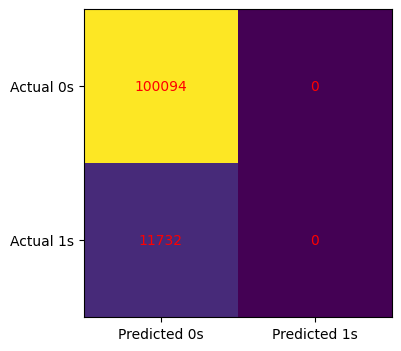

Precision Score: 0.0


In [208]:
model_youth = modelCreation(ihd_with_ig_df_dummy, age_grouping_df['youth'])

No. of Train Datasets: (111826, 5) (111826,)
No. of Test Datasets: (47926, 5) (47926,)

Model Score: 0.8470976088135876

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     37855
           1       0.63      0.66      0.64     10071

    accuracy                           0.85     47926
   macro avg       0.77      0.78      0.77     47926
weighted avg       0.85      0.85      0.85     47926

Confusion Matrix


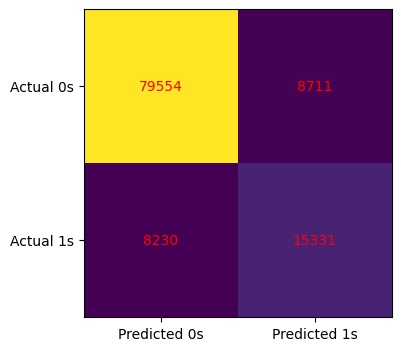

Precision Score: 0.6376757341319358


In [209]:
model_children = modelCreation(ihd_with_ig_df_dummy, age_grouping_df['children'])

## Make Test Prediction<a id="toc-04"></a>

In [210]:
def getPrediction(age_group, model, input):
    df = np.array(input).reshape(1,-1)

    print(f"{age_group.upper()}")

    print(f"Prediction: {model.predict(df)[0]}")
    print(f"Probability Estimates: {model.predict_proba(df)[0]}")
    print()

def testPrediction(date_rate, male_gender, high_income, upper_middle_income, low_middle_income):

    print("DATASET")
    print(f"Male Gender: {male_gender}")
    print(f"High Income: {high_income} | Upper Middle Income: {upper_middle_income} | Low Middle Income: {low_middle_income}")
    print(f"Date Rate: {date_rate}")
    print()
    
    getPrediction('Seniors', model_seniors, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

    getPrediction('Adults', model_adults, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

    getPrediction('Youth', model_youth, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

    getPrediction('Children', model_children, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

In [211]:
date_rate = 700
male_gender = 1
high_income = 0
upper_middle_income = 0
low_middle_income = 1

testPrediction(date_rate, male_gender, high_income, upper_middle_income, low_middle_income)


DATASET
Male Gender: 1
High Income: 0 | Upper Middle Income: 0 | Low Middle Income: 1
Date Rate: 700

SENIORS
Prediction: 1
Probability Estimates: [0.05791397 0.94208603]

ADULTS
Prediction: 0
Probability Estimates: [0.78674002 0.21325998]

YOUTH
Prediction: 0
Probability Estimates: [1.00000000e+00 1.42223266e-65]

CHILDREN
Prediction: 0
Probability Estimates: [1.00000000e+000 7.31501981e-196]



In [212]:
date_rate = 120
male_gender = 1
high_income = 0
upper_middle_income = 0
low_middle_income = 1

testPrediction(date_rate, male_gender, high_income, upper_middle_income, low_middle_income)

DATASET
Male Gender: 1
High Income: 0 | Upper Middle Income: 0 | Low Middle Income: 1
Date Rate: 120

SENIORS
Prediction: 0
Probability Estimates: [0.92147426 0.07852574]

ADULTS
Prediction: 0
Probability Estimates: [0.52871779 0.47128221]

YOUTH
Prediction: 0
Probability Estimates: [1.00000000e+00 3.29318402e-12]

CHILDREN
Prediction: 0
Probability Estimates: [1.00000000e+00 5.00871272e-34]



In [213]:
date_rate = 0
male_gender = 0
high_income = 0
upper_middle_income = 0
low_middle_income = 0

testPrediction(date_rate, male_gender, high_income, upper_middle_income, low_middle_income)

DATASET
Male Gender: 0
High Income: 0 | Upper Middle Income: 0 | Low Middle Income: 0
Date Rate: 0

SENIORS
Prediction: 0
Probability Estimates: [0.88085262 0.11914738]

ADULTS
Prediction: 1
Probability Estimates: [0.49653916 0.50346084]

YOUTH
Prediction: 0
Probability Estimates: [0.70394513 0.29605487]

CHILDREN
Prediction: 1
Probability Estimates: [0.45878877 0.54121123]



## References<a id="toc-05"></a>

- <a id="ref-01">https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death</a>
- <a id="ref-02">https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates</a>
- <a id="ref-03">https://www.who.int/docs/default-source/gho-documents/global-health-estimates/ghe2019_cod_methods.pdf</a>
- <a id="ref-03">https://platform.who.int/mortality/themes/theme-details/topics/indicator-groups/indicator-group-details/MDB/ischaemic-heart-disease</a>